In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pylab as P
from scipy.stats.stats import pearsonr
import time
from matplotlib import cm

from sklearn.decomposition import PCA, FastICA, KernelPCA, FactorAnalysis
from sklearn.model_selection import cross_val_score, train_test_split, validation_curve
from sklearn.random_projection import SparseRandomProjection as SRP
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
from sklearn import metrics
from sklearn.mixture import GaussianMixture as GM
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler


In [2]:
np.random.seed(1)
plt.clf()

In [3]:

def clean_data(data):                      #Remove the rows which have missing information
    dataset = np.copy(data)
    dataset = np.delete(dataset,np.where(dataset==" ?")[0],0)
    return dataset

def quantify_data(data, var_idx):          #Convert the string data into numerical format and create dictionary which defines this relation
    ncols = np.shape(data)[1]
    features = np.array((0))
    for i in (var_idx):
        splitdata = np.hsplit(data[1:],ncols )
        keys = np.unique(splitdata[i])     #Isolate unique elements from each feature
        var_dict = dict(zip(keys,range(len(keys))))   # Create the dictionary describing the class conversions(string-int relation) for each feature
        features = np.append(features,var_dict)
        for k in keys:
            data[np.where(data ==k)] = var_dict[k]    # Replace all the data points
    return features[1:]

def plot_hist(x,labx):               #Create histograms
    P.figure()
    n, bins, patches = P.hist(x,20,histtype='bar', stacked=False)#, color=['green', 'blue'], label=['Salary<50k', 'Salary>50k'])
    P.xlabel(labx)
    P.legend()
    P.show()

def plot(x, y, xlabel, ylabel):     #Create a plot
    plt.figure()
    plt.plot(x,y,color='b')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    plt.close()
    
def scatter(ax, x, y, clr, xlabel, ylabel, title):     #Create a scatter plot
    
    clr_label = {0:'black', 1:'lime', 2:'blue',3:'gold', 4:'c', 5:'green', 6:'red', 7:'darkmagenta' }
    names = {0:'setosa',1:'versicolor',2:'virginica'}
    target_names = np.vectorize(names.get)(clr)
    target_labels =  np.unique(target_names)
    #for label in target_labels:
    #    ax.scatter(x[np.where(target_labels[clr]==label)],y[np.where(target_labels==label)],c=np.vectorize(label_clr.get)(clr),label = label)
    ax.scatter(x,y,c=np.vectorize(clr_label.get)(clr))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    return ax

In [4]:
#Randomized Component Analysis
def func_RCA(n_comp, data):
    
    num_samples, num_features = np.shape(data)[:]
    data_train = np.copy(data)
    eps_range = np.linspace(0.1,0.99,8)
    time_init = time.time()
    clf = SRP(n_components=n_comp, eps=eps_range.tolist(),random_state=11)    #scores.append(np.mean(cross_val_score(clf, data_train, cv=3)))
    transformed_data = clf.fit_transform(data_train)
    time_rca = time.time()-time_init
    print("Projected %d samples from %d to %d" % (num_samples, num_features, n_comp))
    
    return transformed_data,time_rca

#Independent Component Analysis
def func_ICA(n_comp, data):
    
    num_samples, num_features = np.shape(data)[:]
    data_train = np.copy(data)
    time_init = time.time()
    clf = FastICA(n_components=n_comp, random_state=12)    #scores.append(np.mean(cross_val_score(clf, data_train, cv=3)))
    transformed_data = clf.fit_transform(data_train)
    time_ica = time.time() - time_init
    print("Projected %d samples from %d to %d" % (num_samples, num_features, n_comp))
    
    return transformed_data, time_ica

#Principal Component Analysis
def func_PCA(n_comp, data):
    
    num_samples, num_features = np.shape(data)[:]
    data_train = np.copy(data)
    time_init = time.time()
    clf = PCA(svd_solver='full', n_components=n_comp, random_state=13)   
    transformed_data = clf.fit_transform(data_train)
    score = clf.score(data_train)
    time_pca = time.time() - time_init
    print("Projected {} samples from {} to {} with score {}" .format(num_samples, num_features, n_comp, score))
    return transformed_data, time_pca


# Analysis of PCA results
def PCA_Analysis(data):
    data_fit = np.copy(data)
    num_samples, num_features = np.shape(data_fit)[:]  
    num_comp = np.arange(0, num_features+1, 2)

    clf = PCA(svd_solver='full', random_state=10)
    scores_cv = []

    # PCA with Cross Validation
    for n in num_comp:
        clf.n_components = n
        transformed_data_cv = clf.fit_transform(data_fit)
        scores_cv.append(np.mean(cross_val_score(clf, data_fit, cv=3)))
        eigenval = clf.explained_variance_ 
        print("EigenValues for n = {} is {}".format(n, eigenval))
    #print("Number of PCA components - {} and PCA score - {}\n".format(clf.n_components_, clf.score(data_train)))  #score returns average log likelihood over all k validations
    best_numcomp_cv = num_comp[np.argmax(scores_cv)] 

    # PCA_MLE
    clf = PCA(svd_solver='full', n_components='mle')
    transformed_data = clf.fit_transform(data)

    best_numcomp_mle = clf.n_components_    
    scores_mle = clf.score(data_fit)
    eigenval_mle = clf.explained_variance_ 
    print("Best number of components by PCA CV = {} and Cross Validation score = {} ".format(best_numcomp_cv, np.amax(scores_cv)))
    print("Best number of components by PCA MLE = {} and PCA score = {}\n".format(best_numcomp_mle, scores_mle))  #score returns average log likelihood over all k validations
    print("Eigenvalues of PCA analysis are ",eigenval_mle)
    #plot(num_comp, scores_cv, 'Number of PCA Components', 'Score')
    
    
def Silhouette_plots(data, clf='KMeans'):
    num_clusters = np.arange(2,8,1)
    plt.clf()
    fig, axes = plt.subplots(2, 3, figsize=(15,13))
    axes = axes.ravel()
    
    for n, ax in zip(num_clusters, axes):
        if clf=='KMeans':
            clf = KMeans(n_clusters=n, random_state=10)
        elif clf=='EM':
            clf = GM(n_components=n, covariance_type = 'full', random_state=10)
        clf.fit(data)
        clf_labels = clf.predict(data)
        avg_silh_score = metrics.silhouette_score(data, clf_labels)
        sample_silh_coeff = metrics.silhouette_samples(data, clf_labels)
        y_lower = 10
        for i in range(n):
            #Gather all silhouette scores for ith cluster samples and sort them:
            silhcoeff_i = np.sort(sample_silh_coeff[clf_labels==i])
            clr = cm.spectral(1.*i/n)
            
            y_range = np.arange(y_lower, y_lower + np.size(silhcoeff_i))
            
            ax.fill_betweenx(y_range, 0, silhcoeff_i, facecolor=clr, edgecolor=clr, alpha=0.75 )

            # Label the silhouette plots with their cluster numbers at the middle
            ax.text(-0.05, y_lower + 0.5 * np.size(silhcoeff_i), str(i))
            
            y_lower = y_lower+np.size(silhcoeff_i) + 10
    
    #ax.set_title("The silhouette plot for the various clusters.")
        ax.set_xlim([-0.1, 1])
        ax.set_yticks([])
        ax.set_xlabel("The silhouette coefficient values")
        ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
        ax.axvline(x=avg_silh_score, color="red", linestyle="--")

    #ax.set_yticks([])  # Clear the yaxis labels / ticks
    #ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
     
    
    plt.show()
    plt.close()
            
    
# Analysis of ICA and RCA results - Use this - http://scikit-learn.org/stable/auto_examples/plot_johnson_lindenstrauss_bound.html#sphx-glr-auto-examples-plot-johnson-lindenstrauss-bound-py


def Analyse_kmeans(data, i, j, ilabel, jlabel):
    k_means_dict = {'k_means_2': KMeans(n_clusters=2, random_state=10), 'k_means_3': KMeans(n_clusters=3, random_state=10),
              'k_means_init_random': KMeans(n_clusters=3, n_init=1, init='random', random_state=10)}
    clf_label, clf = k_means_dict.keys(), k_means_dict.values()


    plt.clf()
    fig, axes = plt.subplots(2,2, sharex=True, figsize=(12,10))
    data_train = np.copy(data)
    ax = scatter(axes[0,0], data[:,i], data[:,j],  target.astype(np.float), ilabel, jlabel, 'Original')    
    score = []
    k = 0
    for  key, est, ax in zip(clf_label,clf, np.concatenate(axes)[1:]) :
        time_init = time.time()
        est.fit(data)
        labels = est.labels_
        score.append(100.*np.sum(np.equal(labels, target))/len(target))
        time_km = time.time() - time_init
        ax = scatter(ax, data_train[:,i], data_train[:,j],  labels.astype(np.float), ilabel, jlabel, key)
        del labels
    plt.show()
    plt.close()
    return time_km, score


def Analyse_EM(data,  i, j, ilabel, jlabel, gm_dict=None):
    if gm_dict==None:
        gm_dict = {'GM(cov type=Full)': GM(n_components=3, covariance_type = 'full', random_state=10), 'GM(cov type=tied)': GM(n_components=3, covariance_type='tied', random_state=10),
             'GM(cov type=Diagonal)': GM(n_components=3, covariance_type='diag', random_state=10), 'GM(cov type=spherical)':GM(n_components=3, covariance_type='spherical', random_state=10)}
    
    clf_label, clf = gm_dict.keys(), gm_dict.values()

    plt.clf()
    fig, axes = plt.subplots(2,2, sharex=True, figsize=(12,10))
    data_train = np.copy(data)
    ax = scatter(axes[0,0], data[:,i], data[:,j],  target.astype(np.float), ilabel, jlabel, 'Original')    
    score = []
    k = 0
    for  key,  ax in zip(clf_label, np.concatenate(axes)[1:]) :
        time_init = time.time()
        est = gm_dict[key]
        est.fit(data)
        labels = est.predict(data)
        score.append(est.score(data))
        time_km = time.time() - time_init
        print('For {}, time taken = {} and score = {} \n'.format(key, time_km, score[-1]))
        ax = scatter(ax, data_train[:,i], data_train[:,j],  labels.astype(np.float), ilabel, jlabel, key)
        del labels
    plt.show()
    plt.close()
    return time_km, score

# Initial Hypothesis from Analysis of Original data - 

Here, from the dataset information, we know aprior that Iris dataset is originally studied for three species and thus one should ideally get three clusters. Ignoring this fact, we first plot different features to develop an intuition and hypothesis about the dataset. As can be seen from above plots, there seem to be two or three possible clusters for this dataset. While the points in black isolate clearly, its still difficult to draw a clear boundary between red and green points. While the color scheme is introduced using the prediction set, its just to clarify the observation. 

Another interesting thing to note are the correlations between different features. While there is significant correlations between sepal length, petal length and petal width, there is very less correlation of these features with sepal width. This suggest that these components are mutual dependent and thus one would expect ICA methods to not be quite successful. To estimate the significant number of components, let's try PCA - 

/localdata/bkhamesra3/softwares/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


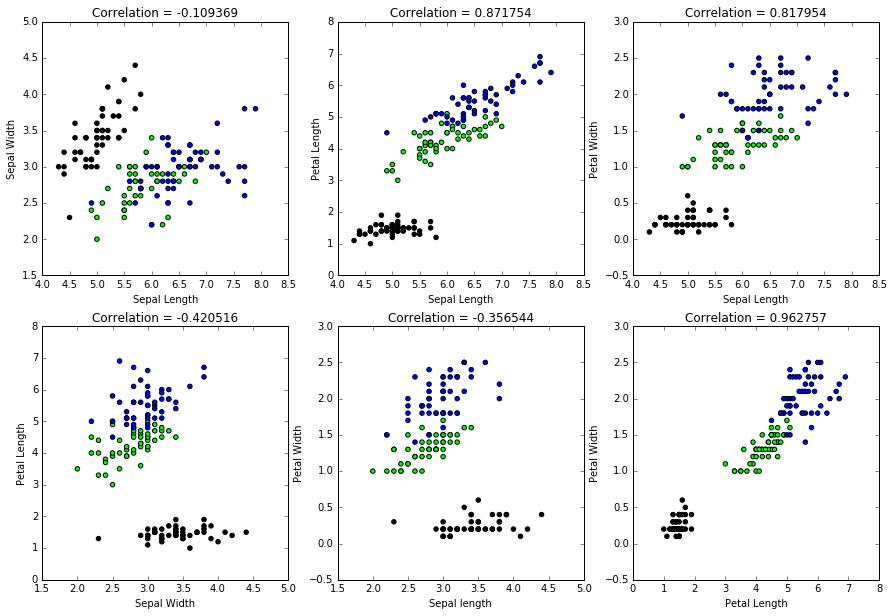

In [5]:
data, target = load_iris().data, load_iris().target
target = target.astype(np.float)
target_names = {0:'setosa',1:'versicolor',2:'virginica'}

correl = np.corrcoef(data.T).T     #Compute the correlations 

plt.clf()
fig, ax = plt.subplots(2,3, figsize=(15,10))
ax[0,0] = scatter(ax[0,0], data[:,0], data[:,1], target, 'Sepal Length', 'Sepal Width', 'Correlation = %f'%correl[0,1])
ax[0,1] = scatter(ax[0,1], data[:,0], data[:,2], target, 'Sepal Length', 'Petal Length', 'Correlation = %f'%correl[0,2])
ax[0,2] = scatter(ax[0,2], data[:,0], data[:,3], target, 'Sepal Length', 'Petal Width', 'Correlation = %f'%correl[0,3])
ax[1,0] = scatter(ax[1,0],data[:,1], data[:,2], target, 'Sepal Width', 'Petal Length', 'Correlation = %f'%correl[1,2])
ax[1,1] = scatter(ax[1,1], data[:,1], data[:,3], target, 'Sepal length', 'Petal Width','Correlation = %f'%correl[1,3]) 
ax[1,2] = scatter(ax[1,2], data[:,2], data[:,3], target, 'Petal Length', 'Petal Width', 'Correlation = %f'%correl[2,3])
plt.legend()
plt.show()
plt.close()

# PCA  Analysis - 
Thus from PCA I find that number of components with best score is 3. Further, from the eigenvalues, we see the information stored in last component is very small and hence can be ignored. 

Let's now try to run clustering algorithms on the complete feature space first. Here, I start with K-Means with varying number of clusters from 2 to 6. In order to determine the optimum number of clusters, I here plot Sepal Length vs Petal Width as its very easy to distinguish the three clusters in that case. Similar plots have already been tried for other features. 

In [6]:
PCA_Analysis(data)

EigenValues for n = 0 is []
EigenValues for n = 2 is [ 4.19667516  0.24062861]
EigenValues for n = 4 is [ 4.19667516  0.24062861  0.07800042  0.02352514]
Best number of components by PCA CV = 4 and Cross Validation score = -10.6175673355 
Best number of components by PCA MLE = 3 and PCA score = -2.53028676961

('Eigenvalues of PCA analysis are ', array([ 4.19667516,  0.24062861,  0.07800042]))


#### KMeans Analysis -
1.  Let us first look at the plots with varying k.

a) As can be seen the results, k means clearly isolates 2 clusters but the results for k>=4 become vague and k>=5 are not reliable. This can be easily seen by comparing k=5 and k=4 where the labels black and yellow points gets flipped.

b) While K-Means is able to cluster points into common  groups, it fails to realize the right labels. For eg. in subplot 2 for k=2 case, the labels of two colors are switched by kmeans which can be seen by flipped colors of labels.

c) The above observations can be explained by the algorithm of K-Means. Since, KMeans takes k number of clusters as input, it will always create k clusters without realizing if such clusters do exist or not. Further, throughout the data, the information about the  right labels is not explicitly provided to kMeans and has no direct method to comupute it. Thus, although it realizes which points fall into same category, it fails to guess the right label. These labels change based on initial selection which can be easily seen by changing the "random_state" parameter of KMeans.

2) In above plots, I vary the k from 2 to 3 and also consider effect of random initialization and k-means++ initialization method. As can be seen the results of both these are comparable with original data plot except the misclassification of labels in random initialization case. 

3) Silhouette Analysis: As can be seen the highest Silhouette score appears for n=3 case. 

 Score for k_means_2 case = 64.7% and time = -0.00571823120117
 Score for k_means_3 case = 89.3% and time = -0.0110518932343
 Score for k_means_4 case = 21.3% and time = -0.0113229751587
 Score for k_means_5 case = 8.7% and time = -0.0103080272675
 Score for k_means_6 case = 31.3% and time = -0.0108938217163


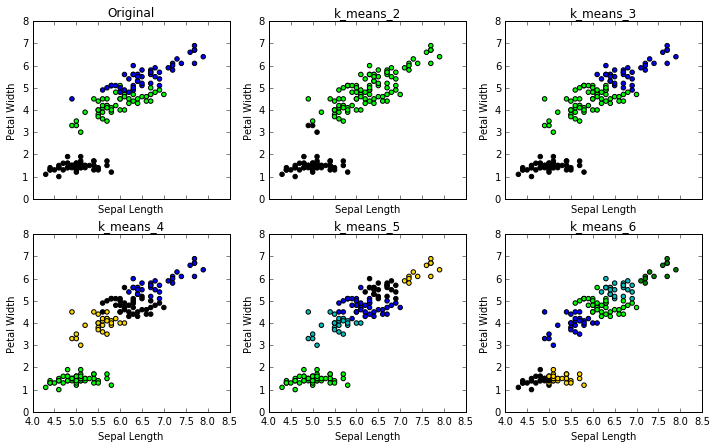

In [7]:
k_means_dict = {'k_means_2': KMeans(n_clusters=2, random_state=10),'k_means_3': KMeans(n_clusters=3, random_state=10), 'k_means_4': KMeans(n_clusters=4, random_state=12),
              'k_means_5': KMeans(n_clusters=5, random_state=10), 'k_means_6':KMeans(n_clusters=6, random_state=10)}
clf_label, clf = k_means_dict.keys(), k_means_dict.values()
i,j = 0,2
ilabel, jlabel = 'Sepal Length', 'Petal Width'
data_train = np.copy(data)
y = np.copy(target)
plt.clf()
fig, axes = plt.subplots(2,3, sharex=True, figsize=(12,7))
data_train = np.copy(data)
ax = scatter(axes[0,0], data[:,i], data[:,j],  target.astype(np.float), ilabel, jlabel, 'Original')    
for  key, est, ax in zip(clf_label,clf, np.concatenate(axes)[1:]) :
    t_begin = time.time()
    est.fit(data_train)
    labels = est.labels_
    t_end = time.time()
    ax = scatter(ax, data_train[:,i], data_train[:,j],  labels.astype(np.float), ilabel, jlabel, key)
    score = np.sum(np.equal(labels, target))
    score = score*100./len(target)
    tnet = t_begin - t_end
    print(" Score for {} case = {}% and time = {}".format(key,round(score,1), tnet))
    del labels
    
plt.show()
plt.close()

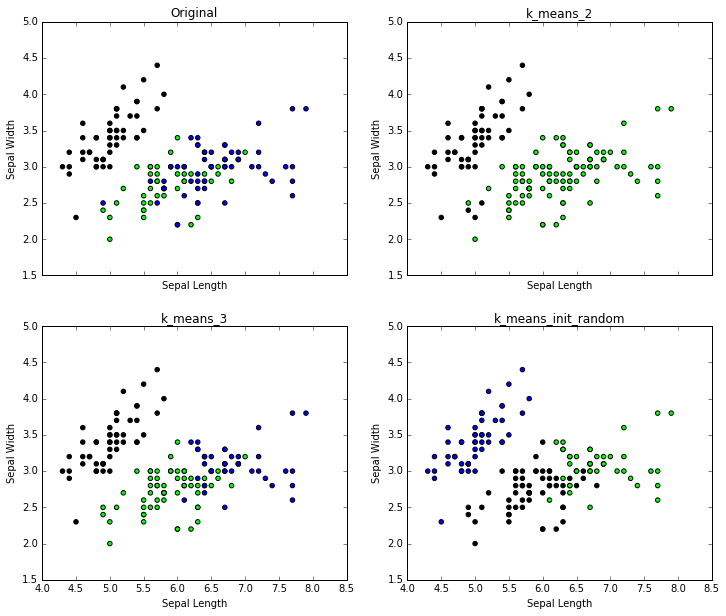

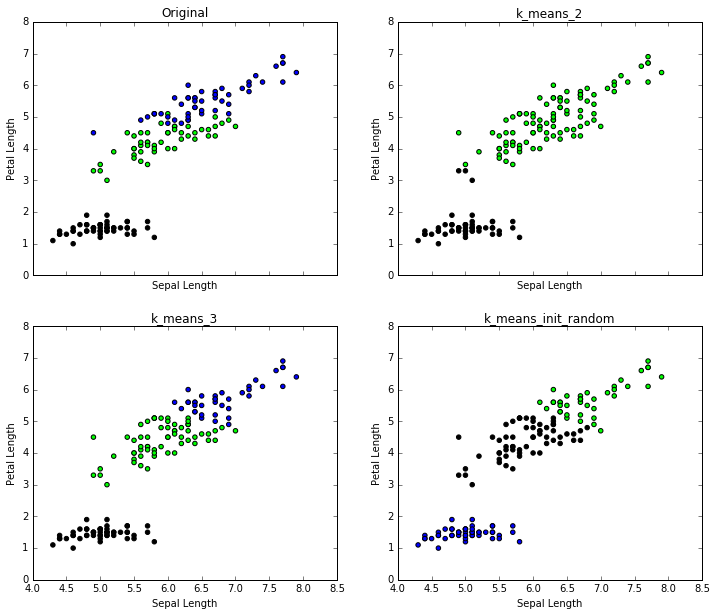

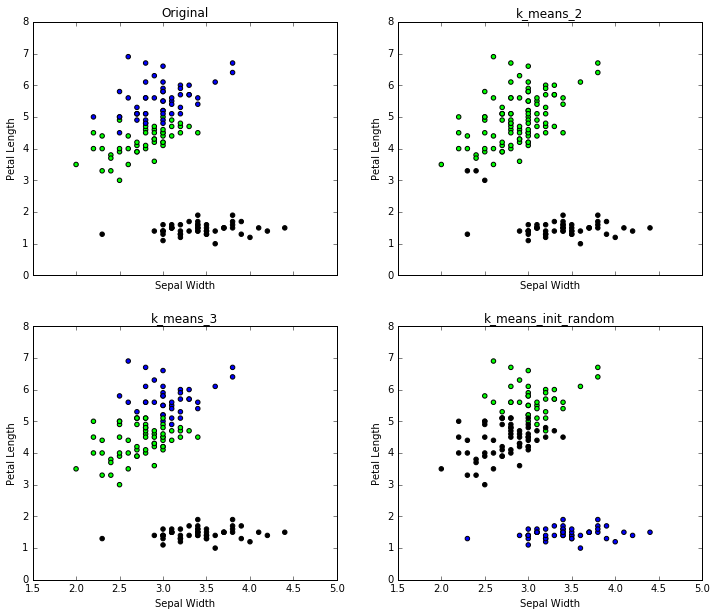

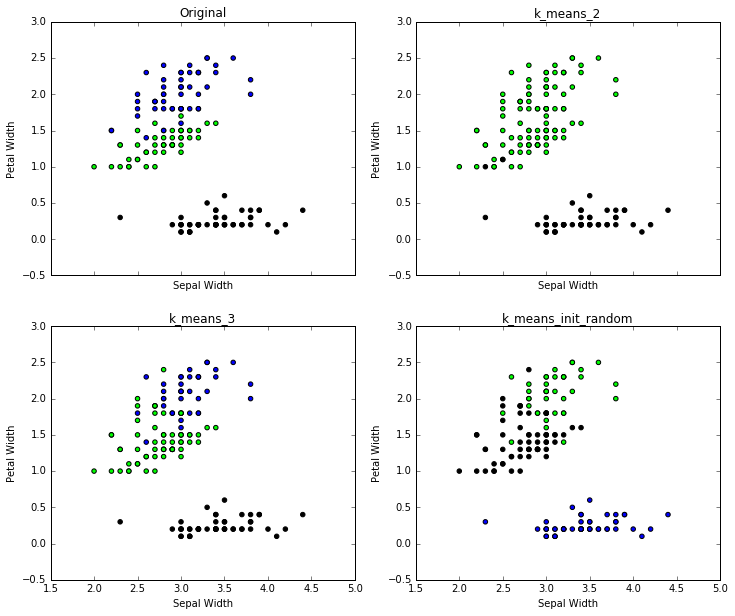

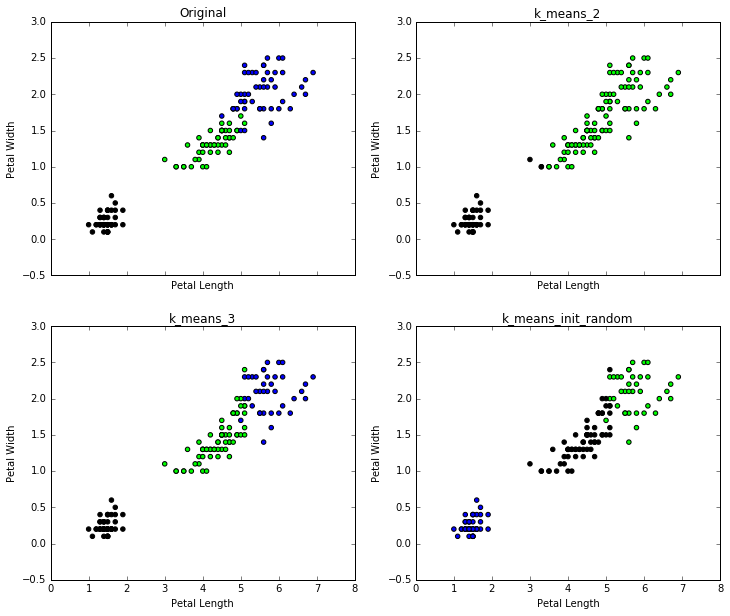

Time taken in k_means = 0.000931024551392
Score in k_means = [64.66666666666667, 89.33333333333333, 2.0]


In [8]:
  
time_km, score_km = Analyse_kmeans(data, 0,1, 'Sepal Length', 'Sepal Width')
time_km, score_km = Analyse_kmeans(data, 0,2, 'Sepal Length', 'Petal Length')
#time_km, score_km = Analyse_kmeans(data, 0,3, 'Sepal Length', 'Petal Width')
time_km, score_km = Analyse_kmeans(data, 1,2, 'Sepal Width', 'Petal Length')
time_km, score_km = Analyse_kmeans(data, 1,3, 'Sepal Width', 'Petal Width')
time_km, score_km = Analyse_kmeans(data, 2,3, 'Petal Length', 'Petal Width')
print("Time taken in k_means = {}".format(time_km))
print("Score in k_means = {}".format(score_km))


# Gaussian Mixture

# Gaussian Mixture - varying covariance type
Here I compare the different covariances. As described on sklearn, different types of covariances are- 
    "'full' (each component has its own general covariance matrix),
    'tied' (all components share the same general covariance matrix),
    'diag' (each component has its own diagonal covariance matrix),
    'spherical' (each component has its own single variance)."
On comparison we find that almost all of the covariance type works quite well in case of Iris database for 2 components. However, in case of three components the labels are again misclassified leading to switching of clusters between Iris Versicolour and Iris Virginica. In comparison with K-Means, Gaussian mixture is more powerful but slower. It not only identifies the clusters but also can tell about the distribution of each cluster by computing the covariance. Thus one has more information about the shape and size of clusters in contrast with k-Means which assumes each cluster to be a sphere. 


For GM(cov type=Diagonal), time taken = 0.00218105316162 and score = -2.05502478075 

For GM(cov type=spherical), time taken = 0.00197601318359 and score = -2.56606476397 

For GM(cov type=tied), time taken = 0.00343680381775 and score = -1.71178001523 



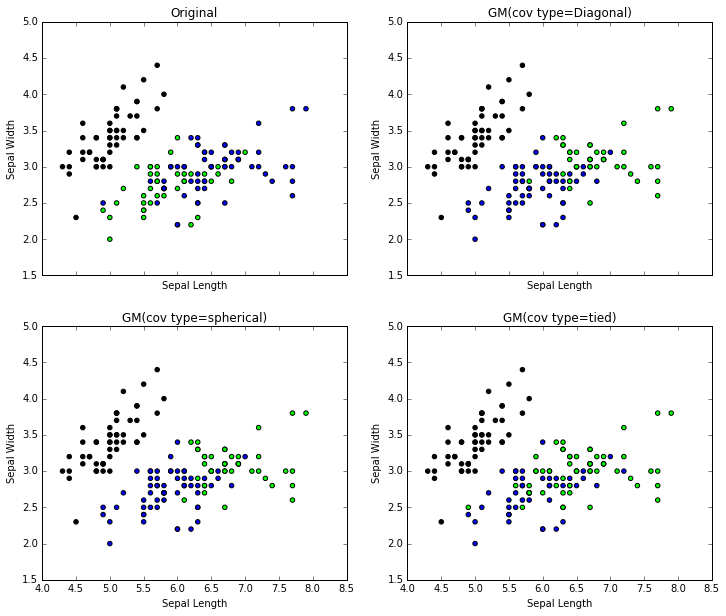

For GM(cov type=Diagonal), time taken = 0.00212097167969 and score = -2.05502478075 

For GM(cov type=spherical), time taken = 0.00209903717041 and score = -2.56606476397 

For GM(cov type=tied), time taken = 0.00361919403076 and score = -1.71178001523 



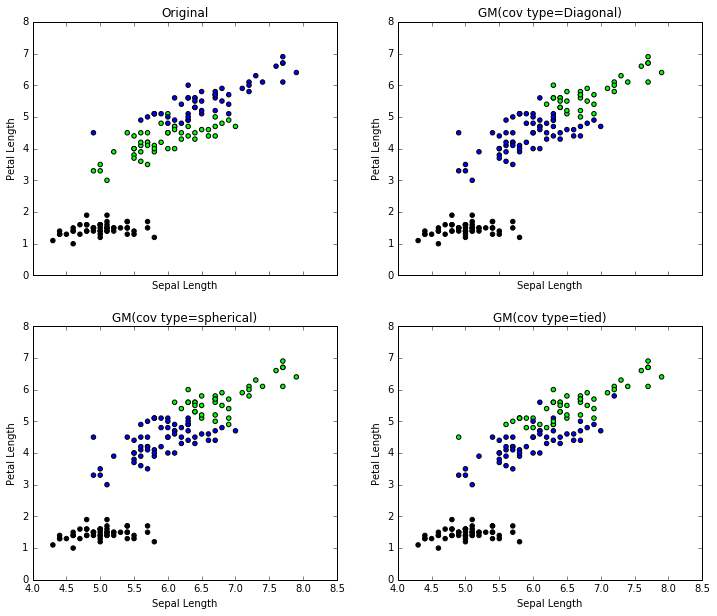

For GM(cov type=Diagonal), time taken = 0.00214314460754 and score = -2.05502478075 

For GM(cov type=spherical), time taken = 0.00197792053223 and score = -2.56606476397 

For GM(cov type=tied), time taken = 0.00344109535217 and score = -1.71178001523 



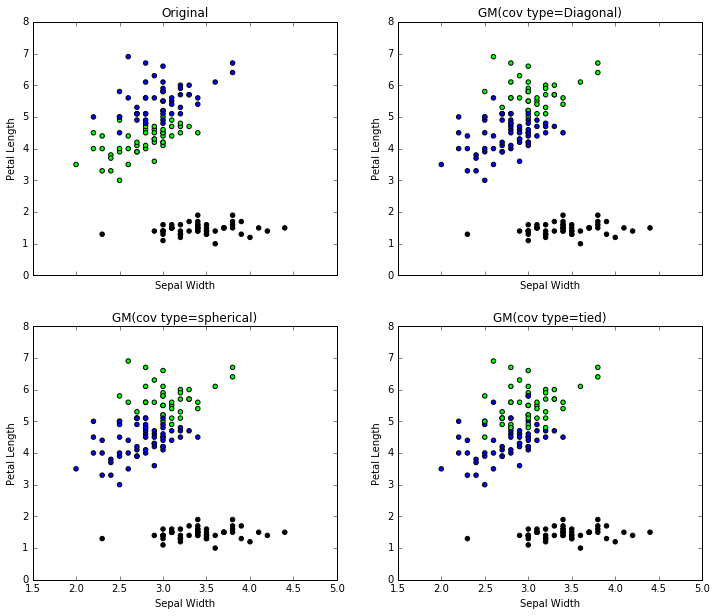

For GM(cov type=Diagonal), time taken = 0.00212407112122 and score = -2.05502478075 

For GM(cov type=spherical), time taken = 0.00203108787537 and score = -2.56606476397 

For GM(cov type=tied), time taken = 0.00341010093689 and score = -1.71178001523 



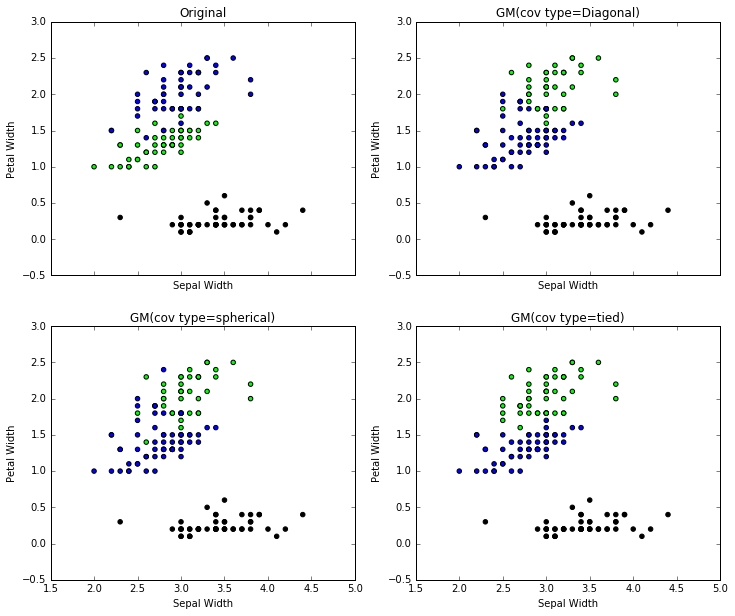

For GM(cov type=Diagonal), time taken = 0.00214099884033 and score = -2.05502478075 

For GM(cov type=spherical), time taken = 0.00198292732239 and score = -2.56606476397 

For GM(cov type=tied), time taken = 0.0034351348877 and score = -1.71178001523 



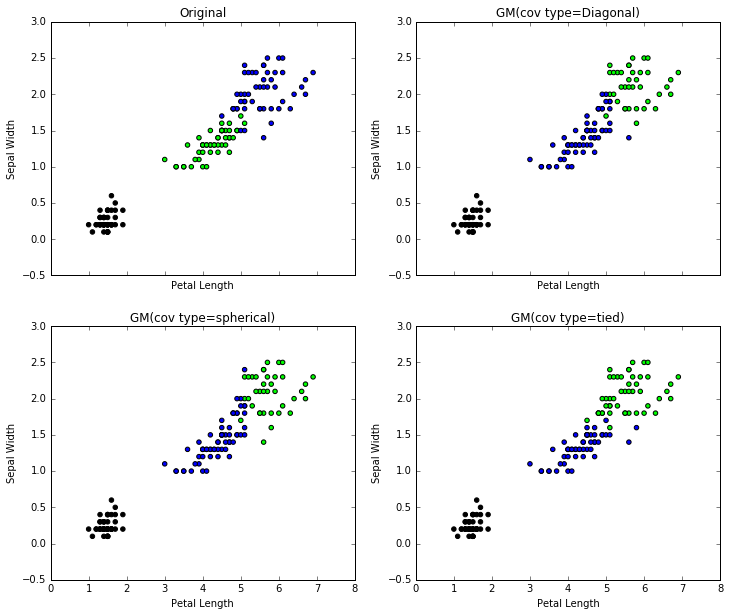

Time taken in Gaussian Mixture = 0.0034351348877
Score in Gaussian Mixture = [-2.055024780754279, -2.5660647639658998, -1.7117800152253342]


In [9]:
  
time_gm, score_gm = Analyse_EM(data, 0,1, 'Sepal Length', 'Sepal Width')
time_gm, score_gm = Analyse_EM(data, 0,2, 'Sepal Length', 'Petal Length')
#time_km, score_km = Analyse_EM(data, 0,3, 'Sepal Length', 'Petal Width')
time_gm, score_gm = Analyse_EM(data, 1,2, 'Sepal Width', 'Petal Length')
time_gm, score_gm = Analyse_EM(data, 1,3, 'Sepal Width', 'Petal Width')
time_gm, score_gm = Analyse_EM(data, 2,3, 'Petal Length', 'Sepal Width')
print("Time taken in Gaussian Mixture = {}".format(time_gm))
print("Score in Gaussian Mixture = {}".format(score_gm))


# Varying number of components:



For GM(n_comp=4), time taken = 0.00700211524963 and score = -1.1192483632 

For GM(n_comp = 5), time taken = 0.0113658905029 and score = -1.01882022833 

For GM(n_comp=3), time taken = 0.00699305534363 and score = -1.20672096043 



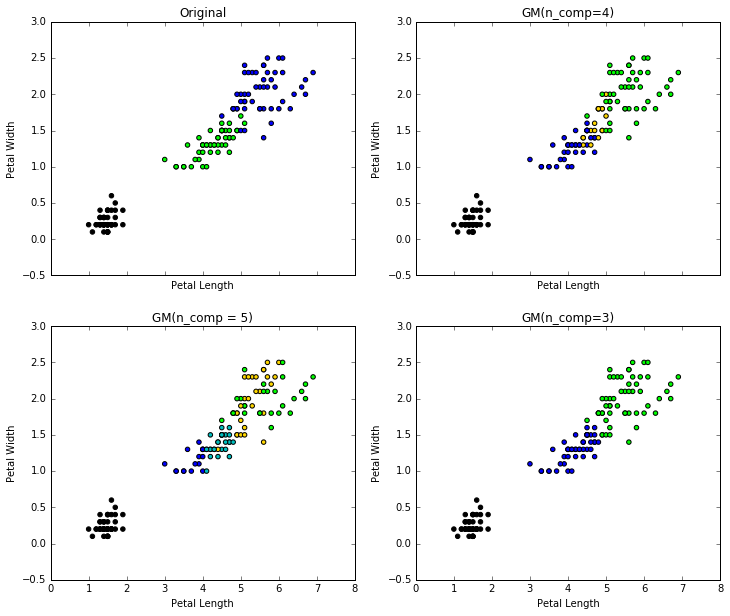

Time taken in gaussian mixtures = 0.00699305534363
Score in gaussian mixtures = [-1.1192483632000536, -1.0188202283292387, -1.2067209604272198]


In [10]:
gm_dict = { 'GM(n_comp = 2)': GM(n_components=2, covariance_type = 'full', random_state=10), 'GM(n_comp=3)': GM(n_components=3, covariance_type='full', random_state=10),
             'GM(n_comp=4)': GM(n_components=4, covariance_type='full', random_state=10), 'GM(n_comp = 5)':GM(n_components=5, covariance_type='full', random_state=10)}

time_gm, score_gm = Analyse_EM(data, 2,3, 'Petal Length', 'Petal Width', gm_dict=gm_dict)
print("Time taken in gaussian mixtures = {}".format(time_gm))
print("Score in gaussian mixtures = {}".format(score_gm))


# Component Analysis

# PCA

As can be seen, the three clusters are much more recognizable in terms of PCA components then in original feature space. This is due to high covariance in the original data which is ideal for PCA. From 1st plot we see that in the PCA components, the data has maximum variance along x-axis while the variance within a cluster is evident along the y axis. Both Gaussian Mixture and K-Means are also able to distiguish between these clusters, however, Gaussian Mixture misclassifies between Iris Versicolour and Iris Virginica while K-Means works here. These results are dependent on chosen randomization of each classifier and varies with change of random state. 

Projected 150 samples from 4 to 3 with score -2.53028676961


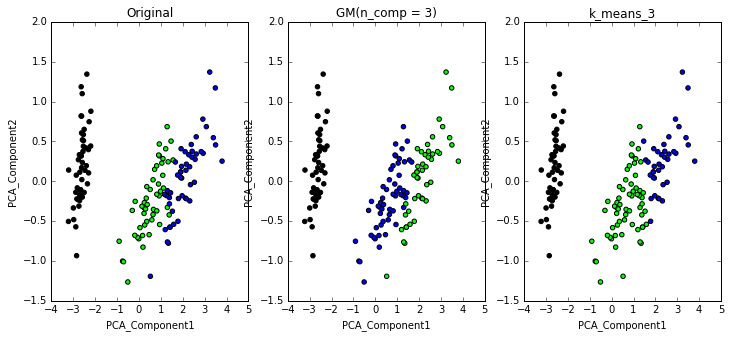

In [11]:
data_pca, time_pca = func_PCA(3, data)
clf = {'GM(n_comp = 3)': GM(n_components=3, covariance_type = 'full', random_state=10),'k_means_3': KMeans(n_clusters=3, random_state=10)}
plt.clf()
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(12,5))
data_train = np.copy(data_pca)
i, j=0,1
ilabel, jlabel = 'PCA_Component1', 'PCA_Component2'
ax = scatter(axes[0], data_train[:,i], data_train[:,j],  target.astype(np.float), ilabel, jlabel, 'Original')    
score = []
k = 0
for  key,  ax in zip(clf.keys(), axes[1:]) :
    time_init = time.time()
    clf[key].fit(data_train)
    if key=='GM(n_comp = 3)':
        labels = clf[key].predict(data_train)
    else:
        labels = clf[key].labels_
    time_km = time.time() - time_init
    ax = scatter(ax, data_train[:,i], data_train[:,j],  labels.astype(np.float), ilabel, jlabel, key)
    del labels
plt.show()
plt.close()
    


Projected 150 samples from 4 to 3 with score -2.53028676961


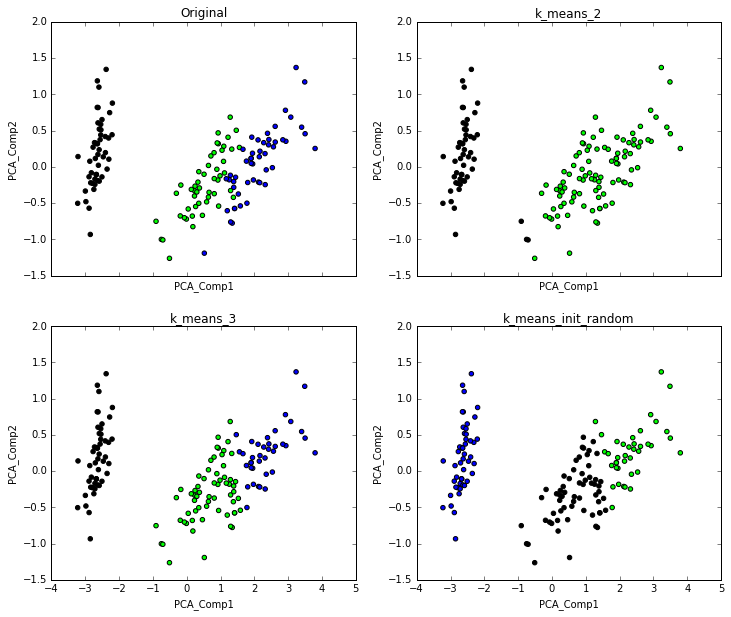

Time for PCA = 0.000724, Time for K-Means = 0.000919, Total Time = 0.001643
('Score by PCA+Kmeans = ', [64.66666666666667, 89.33333333333333, 2.0])


In [12]:
#K-Means:
data_pca, time_pca = func_PCA(3, data)
time_km, score_pca = Analyse_kmeans(data_pca, 0,1, 'PCA_Comp1', 'PCA_Comp2')
print("Time for PCA = %f, Time for K-Means = %f, Total Time = %f"%(time_pca, time_km, time_pca+time_km))
print("Score by PCA+Kmeans = ", score_pca)

Projected 150 samples from 4 to 3 with score -2.53028676961
For GM(cov type=Diagonal), time taken = 0.00168204307556 and score = -2.14054028356 

For GM(cov type=spherical), time taken = 0.00140714645386 and score = -2.5421122948 

For GM(cov type=tied), time taken = 0.0026478767395 and score = -2.18348420096 



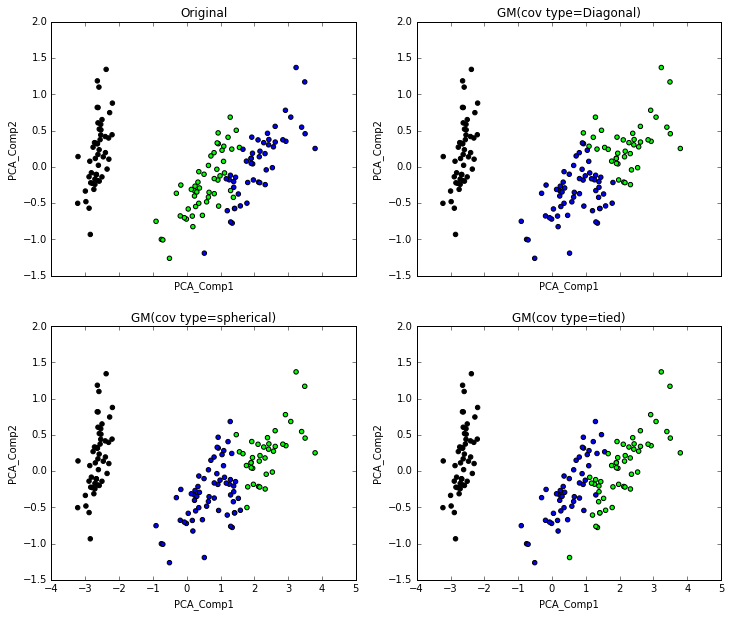

Time for PCA = 0.000676, Time for Gaussian Mixtures = 0.002648, Total Time = 0.003324
('Score by PCA+EM = ', [-2.1405402835604717, -2.5421122947972128, -2.1834842009644233])


In [13]:
#Gaussian Mixture

data_pca, time_pca = func_PCA(3, data)
time_em, score_pca = Analyse_EM(data_pca, 0,1, 'PCA_Comp1', 'PCA_Comp2')
print("Time for PCA = %f, Time for Gaussian Mixtures = %f, Total Time = %f"%(time_pca, time_em, time_pca+time_em))
print("Score by PCA+EM = ", score_pca)

# ICA

The distribution of data in ICA does not lead to a clean distinguiation of clusters as in PCA. This is becase the features are mutually dependent which is against the assumption of ICA. Hence, the resuts of clustering from both K-Means and EM model is bad. However, as seen from the plots, K-Means performs worse with hardly misclassifying almost all the points. 

Projected 150 samples from 4 to 3


/localdata/bkhamesra3/softwares/anaconda2/lib/python2.7/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


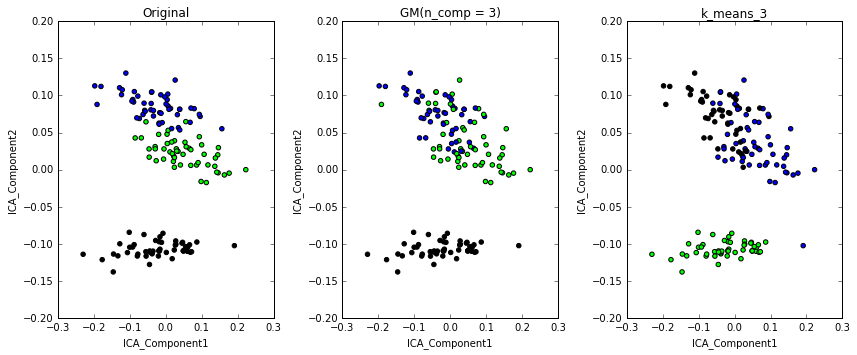

In [14]:
data_ica, time_ica = func_ICA(3, data)

clf = {'GM(n_comp = 3)': GM(n_components=3, covariance_type = 'full', random_state=10),'k_means_3': KMeans(n_clusters=3, random_state=10)}
plt.clf()
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(12,5))
data_train = np.copy(data_ica)
i, j=0,1
ilabel, jlabel = 'ICA_Component1', 'ICA_Component2'
ax = scatter(axes[0], data_train[:,i], data_train[:,j],  target.astype(np.float), ilabel, jlabel, 'Original')    
score = []

for  key,  ax in zip(clf.keys(), axes[1:]) :
    time_init = time.time()
    clf[key].fit(data_train)
    if key=='GM(n_comp = 3)':
        labels = clf[key].predict(data_train)
    else:
        labels = clf[key].labels_
    time_km = time.time() - time_init
    ax = scatter(ax, data_train[:,i], data_train[:,j],  labels.astype(np.float), ilabel, jlabel, key)
    del labels
plt.tight_layout()
plt.show()
plt.close()
    


Projected 150 samples from 4 to 3


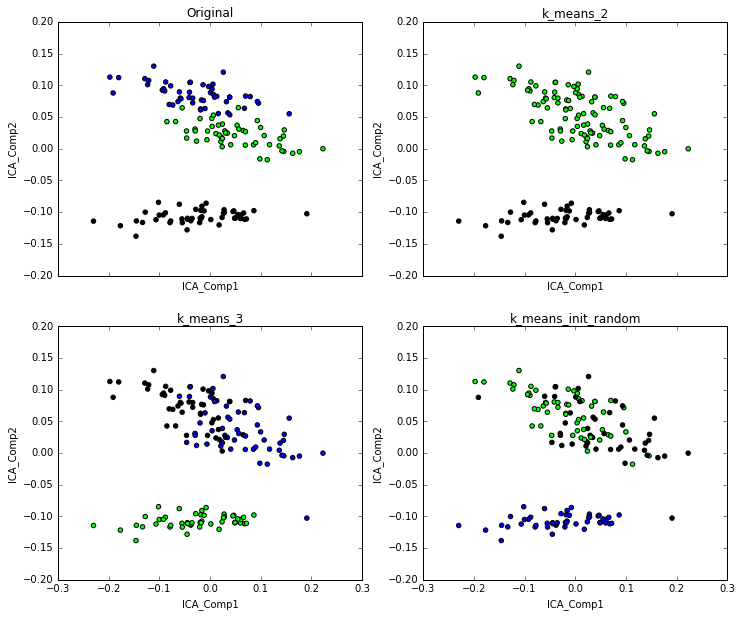

Time for ICA = 0.025816, Time for K-Means = 0.000786, Total Time = 0.026602
('Score by ICA+Kmeans = ', [66.66666666666667, 10.666666666666666, 14.666666666666666])


In [15]:
data_ica, time_ica = func_ICA(3, data)
time_km, score_ica = Analyse_kmeans(data_ica, 0,1, 'ICA_Comp1', 'ICA_Comp2')
print("Time for ICA = %f, Time for K-Means = %f, Total Time = %f"%(time_ica, time_km, time_ica+time_km))
print("Score by ICA+Kmeans = ", score_ica)

Projected 150 samples from 4 to 3
For GM(cov type=Diagonal), time taken = 0.00284194946289 and score = 4.17545142252 

For GM(cov type=spherical), time taken = 0.00338292121887 and score = 3.40364637521 

For GM(cov type=tied), time taken = 0.00274109840393 and score = 3.92689287598 



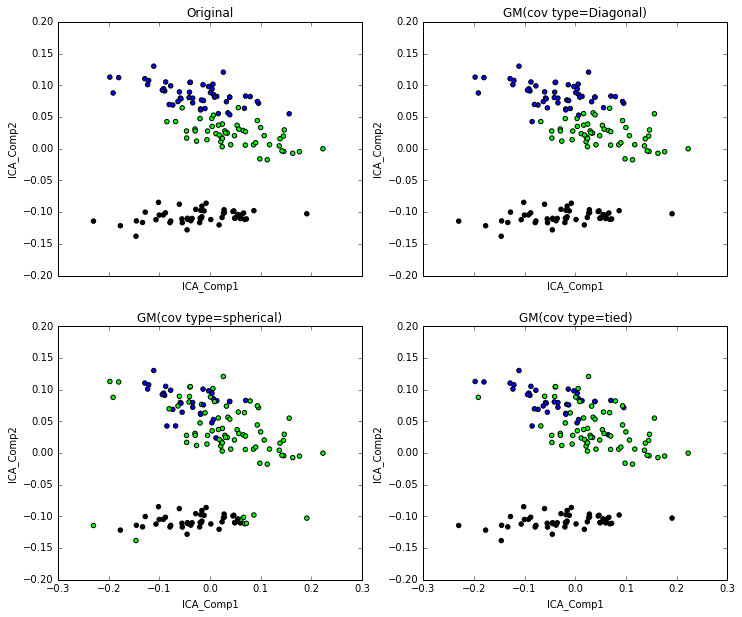

Time for ICA = 0.021703, Time for Gaussian Mixtures = 0.002741, Total Time = 0.024444
('Score by ICA+EM = ', [4.1754514225190418, 3.4036463752094273, 3.926892875976749])


In [16]:
data_ica, time_ica = func_ICA(3, data)
time_em, score_ica = Analyse_EM(data_ica, 0,1, 'ICA_Comp1', 'ICA_Comp2')
print("Time for ICA = %f, Time for Gaussian Mixtures = %f, Total Time = %f"%(time_ica, time_em, time_ica+time_em))
print("Score by ICA+EM = ", score_ica)

# RCA

RCA also performs quite well. Although RCA does not consider covariances, it incorporates some information from almost all the features due to rotation of components. Hence, it performs much better then ICA. As can be seen both EM and K-Means perform quite well here.

Projected 150 samples from 4 to 3


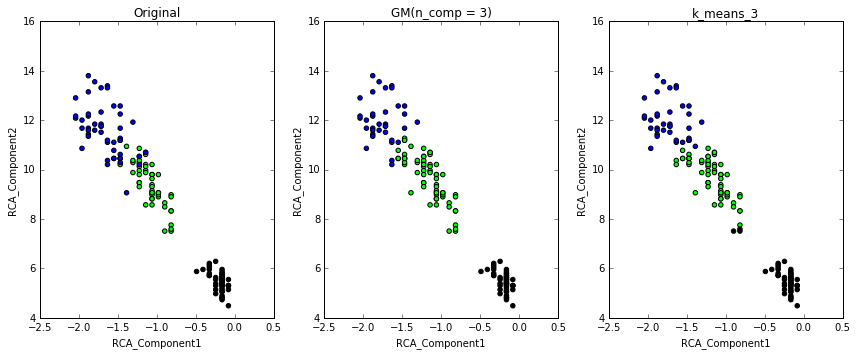

In [17]:
data_rca, time_rca = func_RCA(3, data)
clf = {'GM(n_comp = 3)': GM(n_components=3, covariance_type = 'full', random_state=10),'k_means_3': KMeans(n_clusters=3, random_state=10)}
plt.clf()

fig, axes = plt.subplots(1, 3, sharex=True, figsize=(12,5))
data_train = np.copy(data_rca)
i, j=0,1
ilabel, jlabel = 'RCA_Component1', 'RCA_Component2'
ax = scatter(axes[0], data_train[:,i], data_train[:,j],  target.astype(np.float), ilabel, jlabel, 'Original')    
score = []
k = 0

for  key,  ax in zip(clf.keys(), axes[1:]) :
    time_init = time.time()
    clf[key].fit(data_train)
    if key=='GM(n_comp = 3)':
        labels = clf[key].predict(data_train)
    else:
        labels = clf[key].labels_
    time_km = time.time() - time_init
    ax = scatter(ax, data_train[:,i], data_train[:,j],  labels.astype(np.float), ilabel, jlabel, key)
    del labels
plt.tight_layout()
plt.show()
plt.close()
    

Projected 150 samples from 4 to 3


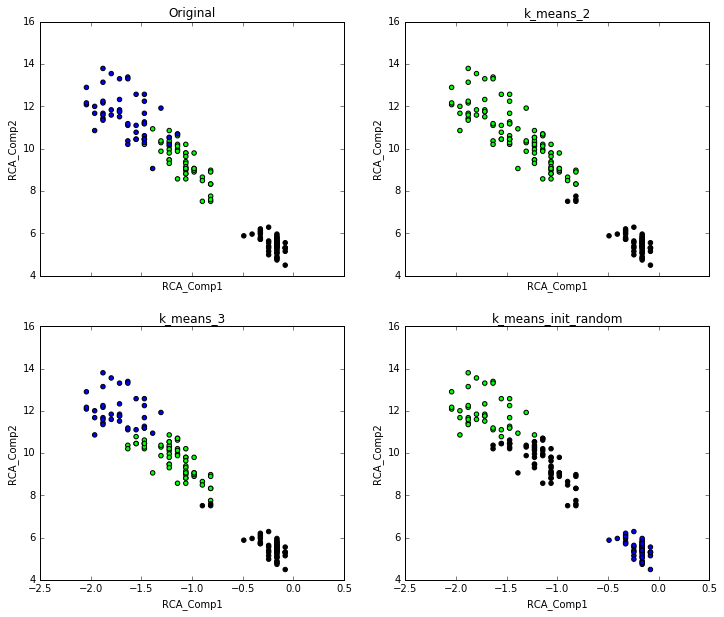

Time for RCA = 0.000682, Time for K-Means = 0.000642, Total Time = 0.001324
('Score by RCA+Kmeans = ', [64.0, 88.0, 1.3333333333333333])


In [18]:
data_rca, time_rca = func_RCA(3, data)
time_km, score_rca = Analyse_kmeans(data_rca, 0,1, 'RCA_Comp1', 'RCA_Comp2')
print("Time for RCA = %f, Time for K-Means = %f, Total Time = %f"%(time_rca, time_km, time_rca+time_km))
print("Score by RCA+Kmeans = ", score_rca)

Projected 150 samples from 4 to 3
For GM(n_comp = 3, cov=Tied), time taken = 0.00272607803345 and score = 4.41788273543 

For GM(n_comp=3, Cov=full), time taken = 0.00288414955139 and score = 4.68528292202 

For GM(n_comp = 2), time taken = 0.00210309028625 and score = 4.60007441412 



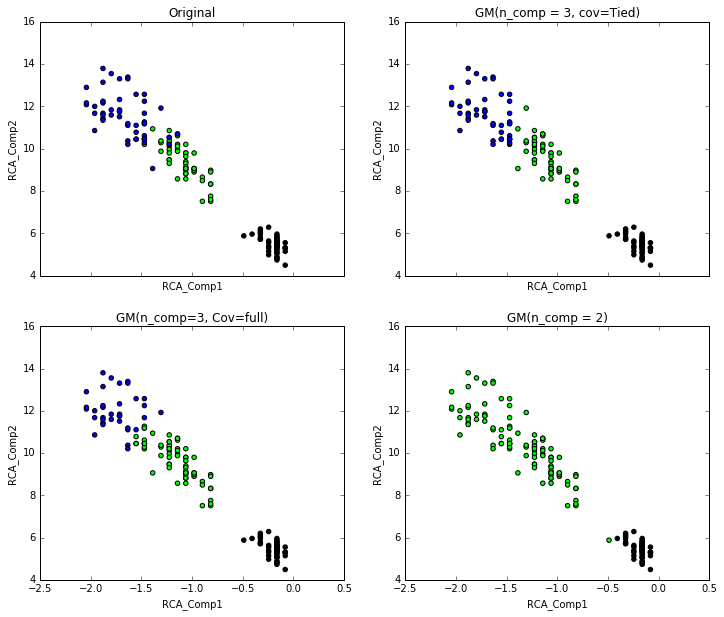

Time for RCA = 0.000545, Time for Gaussian Mixtures = 0.000642, Total Time = 0.001187
('Score by RCA+EM = ', [4.4178827354307595, 4.6852829220165004, 4.6000744141232888])


In [19]:
data_rca, time_rca = func_RCA(3, data)
gm_dict = { 'GM(n_comp = 2)': GM(n_components=2, covariance_type = 'full', random_state=10), 'GM(n_comp=3, Cov=full)': GM(n_components=3, covariance_type='full', random_state=10),
             'GM(n_comp = 3, cov=Tied)':GM(n_components=3, covariance_type='tied', random_state=10)}
time_em, score_rca = Analyse_EM(data_rca, 0,1, 'RCA_Comp1', 'RCA_Comp2', gm_dict=gm_dict)

print("Time for RCA = %f, Time for Gaussian Mixtures = %f, Total Time = %f"%(time_rca, time_km, time_rca+time_km))
print("Score by RCA+EM = ", score_rca)

# PCA Results - 
After dimensionality reduction with PCA, K-Means performs much better with clear identification of 3 distinct clusters. The clustering is performed first with 2 and 3 cluster choices with k-means++ initialization and finally with random initialization on 3 cluster choices. We find that k-means++ performs much better than random initialization. Further, the results improve from two to three clusters. 

# ICA Results - 
As predicted earlier, ICA performs worse in this case which can be clearly explained due to mutually dependent features.Here, ICA ends up with two partially correct clusters but completely break down for three clusters misidentifying them. The results of randomized initialization and k-means++ initialization is same as PCA. 

# RCA Results - 
RCA performs quite well here almost at par with PCA. This is due to the rotation of chosen components which captures the information from all the three features. Surprisingly, RCA is slower than PCA but this might be just due to very small dimensionality. 

# Neural Networks

In [20]:
def NeuralNetworks_with_PCA(clf, pca=True, KM=True):
    data, target = load_iris().data, load_iris().target 
    data_train, data_test, specie_train, specie_test = train_test_split(data, target, train_size = 0.7, random_state=42)
    scalar = StandardScaler()
    scalar.fit(data_train)
    
    data_train = scalar.transform(data_train)
    data_test = scalar.transform(data_test)
    
    if (pca==True):
        data_train, time_pca_train = func_PCA(3,data_train)
        data_test, time_pca_train = func_PCA(3,data_test)

    if (KM==True):
        clstr_clf = KMeans(n_clusters=3, random_state=10)
        clstr_clf.fit(data_train)
    score_cv = cross_val_score(clf, data_train, specie_train, cv=10 )
    clf = clf.fit(data_train, specie_train)
    specie_prediction = clf.predict(data_test)              #Predicts the output y_hat
    prob_prediction = clf.predict_proba(data_test)          #Predicts the success probability of the output = Number of Match/Total test data
    score_test = clf.score(data_test, specie_test) 
    return score_test, specie_prediction

In [21]:
clf = MLPClassifier(alpha=2, hidden_layer_sizes=(3,2), solver='lbfgs',  verbose=False)                        #lbfgs performs faster on small dataset, change to 'adam' for larget dataset
clf_name = "NeuralNetworks"
score_nn, prediction_nn = NeuralNetworks_with_PCA(clf, pca=False, KM=False)
score_pca, prediction_pca = NeuralNetworks_with_PCA(clf, KM=False)
score_cls, prediction_cls = NeuralNetworks_with_PCA(clf)
print("Success of Neural Network without PCA and clustering  = {}, with PCA (no clustering) = {} and with PCA & clustering= {}".format(score_nn, score_pca, score_cls))



Projected 105 samples from 4 to 3 with score -3.37088596297
Projected 45 samples from 4 to 3 with score -3.16278583807
Projected 105 samples from 4 to 3 with score -3.37088596297
Projected 45 samples from 4 to 3 with score -3.16278583807
Success of Neural Network without PCA and clustering  = 0.977777777778, with PCA (no clustering) = 0.866666666667 and with PCA & clustering= 0.288888888889
